## Getting and loading the data 

In [1]:
# control the page size for printing data
ENV["LINES"] = 10
ENV["COLUMNS"] = 250

250

We use the `DLMReader` package to load a csv file into `InMemoryDatasets`, `DLMReader` is a high-performance and versatile package for reading delimited files into `InMemoryDatasets` (there are many alternative packages in Julia ecosystem, users can use any of them to read data into `InMemoryDatasets`):

In [2]:
using InMemoryDatasets
using DLMReader
using PooledArrays
import Downloads

Download the required csv file from internet.

In [3]:
_tmp = Downloads.download("https://raw.githubusercontent.com/sl-solution/InMemoryDatasetsTutorial/main/CA_flights.csv");

Loading data into InMemoryDatasets:

In [4]:
flights = filereader(_tmp, dtformat = Dict(1=>dateformat"y-m-d"));

Convert string columns to `PooledArray`. This is a good practice when the string column only contains few unique values. Here we use `modify!` function to modify a data set. We discuss the `modify!` function later.

In [5]:
modify!(fligths, [:IATA, :Tail_Number, :Origin, :Dest, :CancellationCode] => PooledArray)

Attach a meta information to `flights`:

In [6]:
setinfo!(flights, "Reporting Carrier On-Time Performance for all flights in 2020 from CA.
    Downloaded from www.transtats.bts.gov");

## Filtering the data

In order to select only rows matching certain criteria, use the `filter` function. Note that for referring to a single column in a data set, we can use the column name (a Symbol), the column name as String, or the column index

In [7]:
filter(flights, :FlightDate, by = x->monthday(x)==(1,1)) # or
filter(flights, 1, by = x->monthday(x)==(1,1), view = true) # creating a view of filtered observations

2227×16 SubDataset
  Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance 
      │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity 
      │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64? 
──────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  ⋮   │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮
                                                                                                                                                                         2227 rows omitted

To test if one of two conditions is verified:

In [8]:
filter(flights, :IATA, by = in(("AA", "UA")))

96732×16 Dataset
   Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance 
       │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity 
       │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64? 
───────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ⋮   │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮
                                                                                                                                                                         96732 rows omitted

Filter based on multiple columns: (we can refer to multiple columns by their names or their indices)

In [9]:
filter(flights, [:FlightDate, :IATA], by = [x->monthday(x)==(1,1), in(("UA", "AA"))])

564×16 Dataset
 Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance 
     │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity 
     │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64? 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  ⋮  │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮
                                                                                                                                                                         564 rows omitted

If you apply a function frequently on a column, you can set it as the column's format, and use the `mapformats = true` kewyword arugment in `filter`:
> Note that some functions don't support the `mapformats = true` keyword argument.

We first define formats and then assign them to selected columns:

In [10]:
UA_AA(x) = in(x, ("UA", "AA"))
setformat!(flights, 1=>monthday, 2=>UA_AA);

In [11]:
filter(flights, 1:2, by = [==((1,1)), identity], mapformats = true)

564×16 Dataset
 Row │ FlightDate  IATA     Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance 
     │ monthday    UA_AA    identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity 
     │ Date?       String?  String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64? 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  ⋮  │     ⋮          ⋮          ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮
                                                                                                                                                                        564 rows omitted

`setformat!` doesn't change the actual values of data:

In [12]:
removeformat!(flights, 1:2)

467402×16 Dataset
    Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance 
        │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity 
        │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64? 
────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ⋮    │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮
                                                                                                                                                                         467402 rows omitted

## Select: pick columns by name

You can use the `select!`/`select` functions to select a subset of columns, unlike `select!`, `select` makes a copy of data

In [13]:
select(flights, :DepTime, :ArrTime, :Flight_Number)

467402×3 Dataset
    Row │ DepTime   ArrTime   Flight_Number 
        │ identity  identity  identity      
        │ Int64?    Int64?    Int64?        
────────┼───────────────────────────────────
   ⋮    │    ⋮         ⋮            ⋮
                         467402 rows omitted

`InMemoryDatasets` provides different ways for referring to multiple columns. For instance, let's select all columns between `:FlightDate` and `:Dest` as well as all columns containing "Taxi" or "Delay" in their names. `Between` selects columns between two specified extremes, and regular expressions can be used to select columns with specified patterns.

In [14]:
select(flights, Between(:FlightDate, :Dest), r"Taxi|Delay")

467402×10 Dataset
    Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay 
        │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity 
        │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64? 
────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ⋮    │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮
                                                                                                    467402 rows omitted

## Applying several operations

There are several packages in `Julia` to apply several operations one after the other, here we demonstrate the `Chain` package.

Let's assume we want to select `:IATA` and `:DepDelay` columns and filter for delays over 60 minutes. Since the `:DepDelay` column has missing data, we may want to filter out `missing` values via `dropmissing`.  Here we assume we want a copy of the result (compared to view of the result). Note that `dropmissing` is not making extra copy of data, since we set `view = true`, and by passing a view of `flights` we reduce memory usage. The `@chain` macro automatically fills the first argument of the chained functions, thus, `flights` becomes the first argument of `dropmissing`, the output of `dropmissing` becomes the first argument of `view`, and the output of `view` becomes the first argument of `filter`.

In [15]:
using Chain
delayed =  @chain flights begin
    dropmissing(:DepDelay, view = true)
    view(:, [:IATA, :DepDelay])
    filter(2, by = >(60))
end

10614×2 Dataset
   Row │ IATA      DepDelay 
       │ identity  identity 
       │ String?   Float64? 
───────┼────────────────────
   ⋮   │    ⋮         ⋮
          10614 rows omitted

## Reorder rows

Select `:IATA` and `:DepDelay` columns while sorted by `:DepDelay`. Note that in the following code, `flights[!, [:IATA, :DepDelay]]` is equivalent to `view(flights, :, [:IATA, :DepDelay])`. Further notice that, by defult, calling `sort` on a view of a data set creates a new data set, however, passing `view = true` creates a view of sorted values.

> Note `sort!` and `sort` reorder observations instead of sorting observations by reference (i.e. view of sorted data), however, we can use `groupby` or the combination of `sortperm` and `view` (or by using sort and view of data while passing `view = true`) to create a sorting data set by reference.

In [16]:
sort(flights[!, [:IATA, :DepDelay]], 2)

467402×2 Sorted Dataset
 Sorted by: DepDelay
    Row │ IATA      DepDelay  
        │ identity  identity  
        │ String?   Float64?  
────────┼─────────────────────
   ⋮    │    ⋮          ⋮
           467402 rows omitted

or, in reverse order:

In [17]:
sort(flights[!, [:IATA, :DepDelay]], 2, rev = true)

467402×2 Sorted Dataset
 Sorted by: DepDelay
    Row │ IATA      DepDelay  
        │ identity  identity  
        │ String?   Float64?  
────────┼─────────────────────
   ⋮    │    ⋮          ⋮
           467402 rows omitted

Since `missing` is larger than any number in `Julia`, we drop them and then resort to have a better view of large values. Using `view` helps us to avoid making copies of data.

In [18]:
sort(dropmissing(flights, :DepDelay, view = true)[!, [:IATA, :DepDelay]], 2, rev = true, view = true)

438469×2 SubDataset
    Row │ IATA      DepDelay 
        │ identity  identity 
        │ String?   Float64? 
────────┼────────────────────
   ⋮    │    ⋮         ⋮
          438469 rows omitted

## Add new columns

Use the `modify!` or `modify` (`modify` makes a copy of data) functions to add a column to an existing dataset. In the following example we calculate speed, by dividing distance by air time. Here, we multiply `:Speed` by 60 since `:AirTime` is in minutes - it is also recommended to define functions outside `modify!`, since they will be reusable and the second time you call them no compilation is needed.

In [19]:
m2h(x) = 60x
modify!(flights, [:Distance, :AirTime] => byrow(/) => :Speed, :Speed => byrow(m2h))

467402×17 Dataset
    Row │ FlightDate  IATA      Tail_Number  Flight_Number  Origin    Dest      TaxiOut   TaxiIn    DepDelay  ArrDelay  DepTime   ArrTime   AirTime   Cancelled  CancellationCode  Distance  Speed    
        │ identity    identity  identity     identity       identity  identity  identity  identity  identity  identity  identity  identity  identity  identity   identity          identity  identity 
        │ Date?       String?   String?      Int64?         String?   String?   Float64?  Float64?  Float64?  Float64?  Int64?    Int64?    Float64?  Float64?   String?           Float64?  Float64? 
────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   ⋮    │     ⋮          ⋮           ⋮             ⋮           ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮          ⋮             ⋮             ⋮         ⋮
                                                                                                                                                                                   467402 rows omitted

## Applying functions on each group of observations

To get the average delay for each destination, we `groupby` our data set by `:Dest` (if the order of original data set should be preserved, we must use `gatherby`), select `:ArrDelay` and compute the mean:

In [20]:
combine(groupby(flights, :Dest), :ArrDelay => mean)

120×2 Dataset
 Row │ Dest      mean_ArrDelay 
     │ identity  identity      
     │ String?   Float64?      
─────┼─────────────────────────
  ⋮  │    ⋮            ⋮
               120 rows omitted

we can summarise several columns at the same time, e.g. for each carrier, calculate the minimum and maximum arrival and departure delays: (`InMemorydatasets.jl` automatically handles missing values for common functions like `sum`, `mean`, `maximum`, `minimum`, etc. Refer to manual for more details)

In [21]:
@chain flights begin
    groupby(:IATA)
    combine(r"Delay" => [minimum, maximum]) # apply every functions in the list to each column 
end

14×5 Dataset
 Row │ IATA      minimum_DepDelay  maximum_DepDelay  minimum_ArrDelay  maximum_ArrDelay 
     │ identity  identity          identity          identity          identity         
     │ String?   Float64?          Float64?          Float64?          Float64?         
─────┼──────────────────────────────────────────────────────────────────────────────────
  ⋮  │    ⋮             ⋮                 ⋮                 ⋮                 ⋮
                                                                         14 rows omitted

For each day of the year, count the total number of flights and sort in descending order:

In [22]:
@chain flights begin
    setformat!(1 => day) # format date as day
    gatherby(1)
    combine(1 => length => :count)
    sort!(2, rev = true)
end

31×2 Sorted Dataset
 Sorted by: count
 Row │ FlightDate  count    
     │ day         identity 
     │ Date?       Int64?   
─────┼──────────────────────
  ⋮  │     ⋮          ⋮
             31 rows omitted

For each month of the year, calculate the cancellation rate:


In [23]:
pct_fmt(x) = string(round(x*100, digits = 2), "%") # we use this as format for displaying values
@chain flights begin
    setformat!(1 => month)
    groupby(:FlightDate)
    combine(:Cancelled => mean => :Percent)
    setformat!(:Percent => pct_fmt)
end

12×2 Dataset
 Row │ FlightDate  Percent  
     │ month       pct_fmt  
     │ Date?       Float64? 
─────┼──────────────────────
  ⋮  │     ⋮          ⋮
             12 rows omitted

For each destination, count the total number of flights and the number of distinct planes that flew there


In [24]:
@chain flights begin
    groupby(:Dest)
    # Julia broadcasting also can be used to specify transformations
    combine(:Tail_Number .=> [length, length∘union] .=> [:Count, :Unique_Flight])
end

120×3 Dataset
 Row │ Dest      Count     Unique_Flight 
     │ identity  identity  identity      
     │ String?   Int64?    Int64?        
─────┼───────────────────────────────────
  ⋮  │    ⋮         ⋮            ⋮
                         120 rows omitted

Cross tabulate airports with more than 1000 distinct planes flying between them

In [25]:
@chain flights begin
    groupby([:Origin, :Dest])
    combine(:Tail_Number => length∘union)
    filter(3, by = >(1000))
    gatherby(1, isgathered = true)
    # setting `variable_name = nothing` drop it from the output dataset
    transpose(3, id = 2, variable_name = nothing, default = 0)
end

4×8 Dataset
 Row │ Origin    ATL       DEN       LAS       PHX       SFO       LAX       SAN      
     │ identity  identity  identity  identity  identity  identity  identity  identity 
     │ String?   Int64?    Int64?    Int64?    Int64?    Int64?    Int64?    Int64?   
─────┼────────────────────────────────────────────────────────────────────────────────
  ⋮  │    ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮
                                                                        4 rows omitted

## Non-reduction functions

In the previous section, we always applied functions that reduced a vector to a single value.
Non-reduction functions instead take a vector and return a vector. For example we can rank, within each `:IATA`, how much
delay a given flight had and figure out the day and month with the two greatest delays:


In [26]:
most_delay(x, y) = x[first(sortperm(y, by = -),2)]
@chain flights begin
    groupby(:IATA)
    combine((:FlightDate, :DepDelay) => most_delay => :Most_Delay)
    setformat!(2 => monthday)
end

28×2 Dataset
 Row │ IATA      Most_Delay 
     │ identity  monthday   
     │ String?   Date?      
─────┼──────────────────────
  ⋮  │    ⋮          ⋮
             28 rows omitted

We could use Julia partial sorting too.

> **performance tip:** If you'll group often by the same column(s), you can use `groupby!` or `sort!` functions to sort your data set by that column(s) at once to optimise future computations. The difference between `groupby!` and `sort!` is that the former one sorts and marks data as grouped, but the latter one only sorts data.

For each month, calculate the number of flights and the change from the previous month

In [27]:
@chain flights begin
    setformat!(1 => month)
    groupby(1)
    combine(1 => length => :length)
    # parenthesis is needed when a lambda function is used
    modify!(:length => (x-> x .- lag(x)) => :change)
end

12×3 Dataset
 Row │ FlightDate  length    change   
     │ month       identity  identity 
     │ Date?       Int64?    Int64?   
─────┼────────────────────────────────
  ⋮  │     ⋮          ⋮         ⋮
                       12 rows omitted

## Visualising your data

The [StatsPlots](https://github.com/JuliaPlots/StatsPlots.jl), [VegaLite](https://github.com/queryverse/VegaLite.jl), [Makie](https://github.com/JuliaPlots/Makie.jl) packages (among others) make a rich set of visualisations possible with an intuitive syntax.

Here we use `VegaLite` to visualise the cancellation rate in busiest airports for each month:

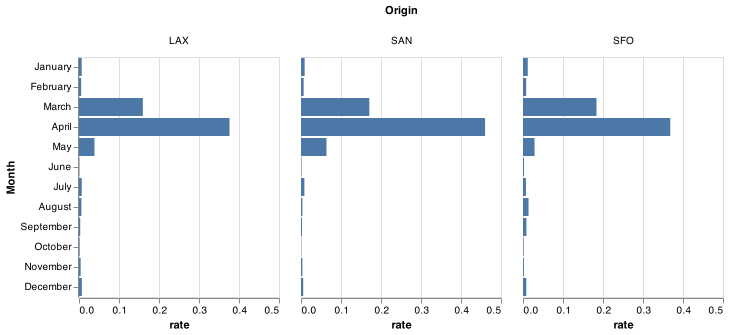

In [28]:
using VegaLite
@chain flights begin
    groupby([:FlightDate, :Origin])
    combine(:Cancelled => mean => :rate)
    filter!(:Origin, by = in(["LAX", "SFO", "SAN"]))
    map(monthname, 1)
    # in Chain "_" refers to the output of preceding command
    _ |> @vlplot(:bar,
            y = {"FlightDate:o", title = "Month", sort = false},
            x = "rate",
            column = "Origin:n"
        )
end